In [ ]:
# import packages
import h5py # read h5

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from matplotlib import rc
from cycler import cycler

import numpy as np
import pandas as pd

from merge_h5_files import merge_preserve_time
import os
import glob

# download and install Dr. Jin's python package, click the url below for more details
# !git clone https://github.com/jinwar/jin_pylib

from jin_pylib import gjsignal
from jin_pylib import Data2D_XT


# merge dataset

In [7]:
# Read h5 files
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 3 (refrac)/Neubrex_DSS_strain/Zgabay A14H - refrac - strain change.h5','r')
f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/HFTS2_dataset/stage6/sensor_2019-04-01T180047Z.h5','r')
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/HFTS2_dataset/stage22/sensor_2019-04-07T033627Z.h5','r')
print(list(f1.keys()))
# 继续进入下一层
data_group = f1['Acquisition']['Raw[0]']['RawData']
print(data_group)
# print(list(data_group.keys()))
# 继续进入下一层
# data_group2 = data_group['Raw[0]']
# print(list(data_group2.keys()))
# 继续进入下一层
# RawData = data_group2['RawData']
# print(RawData)
# RawDataTime = data_group2['RawDataTime']
# print(RawDataTime)

['Acquisition']
<HDF5 dataset "RawData": shape (6100, 30), type "<i4">


In [ ]:

folder  = r"C:/Users/fengxiang.mao/Desktop/HFTS2_dataset/stage22"
pattern = "sensor_*.h5"  # 或者 "*.h5"
out_h5  = os.path.join(folder, "merged_stage22_preserve_time.h5")

files = sorted(glob.glob(os.path.join(folder, pattern)))
assert files, f"在 {folder} 未找到匹配 {pattern} 的文件。"

# Merge HFTS2 h5 files while preserving time information
# （depth, time）no need to transpose
merge_preserve_time(files, out_h5,
                    expected_depth=6100,
                    expected_T_per_file=30,
                    sort_by_time=True,
                    compression=None)  # 需要压缩可设 'gzip', compression_opts=4

合并完成：C:/Users/fengxiang.mao/Desktop/HFTS2_dataset/stage22\merged_stage22_preserve_time.h5
  /Acquisition/Raw[0]/RawData 形状: (6100, 2400)
  /Acquisition/Raw[0]/RawDataTime 形状: (2400,)
  还写入了 /Acquisition/FileNames 与 /Acquisition/FileOffsets（便于追溯映射）


# axes calibration

In [1]:
# import packages
import h5py # read h5

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from matplotlib import rc
from cycler import cycler
from depth_and_time_cut import subset_dstrain_by_time_ranges, subset_dstrain_by_md_ranges

import numpy as np
import pandas as pd


# download and install Dr. Jin's python package, click the url below for more details
# !git clone https://github.com/jinwar/jin_pylib

from jin_pylib import gjsignal
from jin_pylib import Data2D_XT


In [2]:
# Read h5 files
# f1 = h5py.File('C:/Users/fengxiang.mao/Desktop/Devon data/HFTS-1_Devon/20220707/Evo 3 (refrac)/Neubrex_DSS_strain/Zgabay A14H - refrac - strain change.h5','r')
# merged_data = h5py.File('C:/Users/fengxiang.mao/Desktop/HFTS2_dataset/stage6/merged_stage6_preserve_time.h5','r')
merged_data = h5py.File('C:/Users/fengxiang.mao/Desktop/HFTS2_dataset/stage22/merged_stage22_preserve_time.h5','r')
print(list(merged_data.keys()))

['Acquisition']


In [3]:
# Assign variables
dstrain = (merged_data['Acquisition']['Raw[0]']['RawData'])
# depth = (f1['depth'])
time_relative = (merged_data['Acquisition']['Raw[0]']['RawDataTime'])

# use panda package
# print(pd.DataFrame(dstrain))
print(pd.DataFrame(dstrain))
# print(pd.DataFrame(date_plot))

        0       1       2       3       4       5      6       7       8     \
0     -11933     303    4010   -3881   10919   -2240  -2492    5646   21882   
1      -9218  112709  135840   23604   25881   43442 -19578   33118   84532   
2      61427 -111187 -272225 -120076   86807    4261 -35714  -13201 -235525   
3     -17842  -80489 -466769 -232599  204741  -20341 -77644  -26502 -430356   
4       6866 -113127 -514831 -219508  195350   -9196 -83294  -80521 -524252   
...      ...     ...     ...     ...     ...     ...    ...     ...     ...   
6095 -125938 -253710  -37046 -100370  189420  251166  88097  328733  359512   
6096   21972 -102141    3208  181077  -67610 -257023 -70351   55693  -64346   
6097 -126561 -140775   17005  -22210    5268   12318  -5884  135585   93290   
6098   15834   53768  132003  -96437  -43064   41247  49210  143907  -31042   
6099  -44214  -97734   83276  -13782 -165050   11235  -2991  -87606 -230814   

        9     ...    2390    2391    2392    2393  

In [4]:
# convert the strain data to numpy array
dstrain = np.array(dstrain)
print(dstrain.shape)

# date_plot = np.array(date_plot)

(6100, 2400)


In [5]:
# Parameters
sp_resolution = 1.0209523439407349    # Spatial resolution, m
time_resolution = 10     # Time resolution, s
optical_dis_top = 327.20279999999997  # Optical distance to top, m
optical_dis_end = 6198.7121136000005  # Optical distance to bottom, m
physical_dis_top = -4.440892098500626E-15      # Physical distance to top, m
physical_dis_end = 5840.0656312500005  # Physical distance to bottom, m
kelly_bushing = 7.9248   # Kelly bushing height, m


# Convert meters to feet
def meters_to_feet(meters):
    return meters * 3.28084

sp_resolution_ft = meters_to_feet(sp_resolution)
optical_dis_top_ft = meters_to_feet(optical_dis_top)
optical_dis_end_ft = meters_to_feet(optical_dis_end)
physical_dis_top_ft = meters_to_feet(physical_dis_top)
physical_dis_end_ft = meters_to_feet(physical_dis_end)
kelly_bushing_ft = meters_to_feet(kelly_bushing)


# Compute MD (measured depth) for a range of channel counts in a vectorized way
min_channels = 0
max_channels = 6099
channels = np.arange(min_channels, max_channels + 1)
fiber_MD = channels * sp_resolution_ft 
MD = (fiber_MD - optical_dis_top_ft) * (physical_dis_end_ft - physical_dis_top_ft) / (optical_dis_end_ft - optical_dis_top_ft)  + kelly_bushing_ft

print(MD)
print(MD.shape)

[-1041.75112088 -1038.4194776  -1035.08783432 ... 19271.27796929
 19274.60961257 19277.94125585]
(6100,)


In [6]:

# ranges = [(17350, 18180)]
ranges = [(13500, 14500)]

# 已有：dstrain.shape == (N_ch, N_t)、MD.shape == (N_ch,)
# ranges 用 MD（ft）指定

# A) 推荐：严格按 MD 边界插值（边界精确）
data_sub, md_sub, meta = subset_dstrain_by_md_ranges(
    dstrain, MD, ranges,
    method="interp",
    keep_gaps=True,   # 区间之间空白隔开，瀑布图更清晰
    gap_rows=2,
)

# B) 若追求速度且能接受边界落到最近 channel：
# data_sub, md_sub, meta = subset_dstrain_by_md_ranges(dstrain, MD, ranges, method="nearest_channel", keep_gaps=True)


In [7]:
print(data_sub.shape)
print(md_sub.shape)
print(data_sub)


(302, 2400)
(302,)
[[-2.24145444e+02 -3.89123466e+03 -2.21297266e+02 ...  9.51522482e+02
   6.99274116e+02  9.03473187e+02]
 [-9.20000000e+01  3.00000000e+00  4.41000000e+02 ...  9.23000000e+02
   4.97000000e+02  7.92000000e+02]
 [ 4.12000000e+02  1.85000000e+02  4.87000000e+02 ...  9.77000000e+02
   8.54000000e+02  1.03800000e+03]
 ...
 [-1.12800000e+03  1.28000000e+02  2.19000000e+02 ...  8.40000000e+01
  -4.67000000e+02 -3.70000000e+01]
 [ 5.32400000e+03  4.29700000e+03  1.85600000e+03 ...  1.83000000e+02
  -4.27000000e+02  1.30000000e+01]
 [-3.03341415e+03  9.29185732e+03  3.12586389e+03 ...  1.71423401e+02
  -9.30596372e+01  3.97152290e+01]]


In [8]:
t_intrvl = 10  # time interval in seconds
t_axis =  t_intrvl * np.arange(dstrain.shape[-1])          # array([1, 146, 291, ...])
t_axis = t_axis.tolist() 
print(t_axis)
print(type(t_axis))
# start_time = datetime.datetime(2019,4,1,18,00,47)
start_time = datetime.datetime(2019,4,7,3,31,27)
# print(start_time)


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1490, 1500, 1510, 1520, 1530, 1540, 1550, 1560, 1570, 1580, 1590, 1600, 1610, 1620, 1630, 1640, 1650, 1660, 1670, 1680, 1690, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1780, 1790, 1800, 1810, 1820, 1830, 1840, 

In [ ]:

# 例1：用“相对秒”指定两段
# ranges_t = [(0, 3600), (7200, 7800)]   # [0, 1h] 和 [2h, 2h10m]

# 例2：用“绝对时间”指定（需要 start_time）
from datetime import timedelta
# ranges_t = [(start_time + timedelta(minutes=0), datetime.datetime(2019,4,2,1,00,47))]
ranges_t = [(start_time + timedelta(minutes=0), datetime.datetime(2019,4,7,10,6,27))]    #这个时间是文件开始的时间，里面还有29个intervals

# ranges_t = [(start_time + timedelta(minutes=5), start_time + timedelta(minutes=30)),
#             (start_time + timedelta(hours=2),  start_time + timedelta(hours=2, minutes=10))]

# A) 边界精确（推荐）
data_tsub, t_sub, tmeta = subset_dstrain_by_time_ranges(
    data_sub, t_axis, ranges_t,
    start_time=start_time,
    method="interp",
    keep_gaps=True,
    gap_cols=2,
    include_endpoints=True
)

# B) 速度优先（不插值）
# data_tsub, t_sub, tmeta = subset_dstrain_by_time_ranges(
#     dstrain, t_axis, ranges_t, start_time=start_time, method="nearest", keep_gaps=True
# )


In [11]:
import numpy as np
import pandas as pd

# t：把你的 t_axis 统一成“相对秒”的 ndarray
t = np.asarray(t_axis, dtype=float)
dt = float(np.median(np.diff(t)))  # 估计采样间隔，应≈10

# 把你传给函数的 ranges_t（若是绝对时间）也转为“相对秒”
def to_rel_s(r, start_time):
    lo, hi = r
    lo = (pd.to_datetime(lo) - pd.to_datetime(start_time)).total_seconds()
    hi = (pd.to_datetime(hi) - pd.to_datetime(start_time)).total_seconds()
    return lo, hi

# 如果你的 ranges_t 就是相对秒，这步就不用
lo, hi = to_rel_s(ranges_t[0], start_time)

print("t[0], t[-1], dt =", t[0], t[-1], dt)
print("你给的区间(秒)   =", lo, hi)
print("左侧被裁掉列数 =", np.sum(t < lo))
print("右侧被裁掉列数 =", np.sum(t > hi))


t[0], t[-1], dt = 0.0 23990.0 10.0
你给的区间(秒)   = 0.0 23700.0
左侧被裁掉列数 = 0
右侧被裁掉列数 = 29


In [10]:
print(data_tsub.shape)

(302, 2371)


# Waterfall plot

In [14]:
# Figure format
rc = {'axes.facecolor':'white',
      'figure.figsize': (12, 6),
      'savefig.dpi': 600,
#       'axes.grid' : False,
      'axes.edgecolor' : '0.15',
      'font.family':'Times New Roman',
      'axes.labelsize': 20,         # X、Y 轴标题字体
      'axes.labelweight': 'bold',   # X、Y 轴标题加粗
      'xtick.labelsize': 20,        # X轴刻度文字
      'ytick.labelsize': 20,        # Y轴刻度文字
      'legend.fontsize': 20,       # 图例字体

      # 线宽与颜色顺序
      'lines.linewidth': 2.25,      # 所有线条默认 2.25 pt
      'axes.prop_cycle': cycler('color', list(('k', 'r', 'b', 'g', 'm', 'c', 'y'))),

      # 刻度朝外 & 粗细
      'xtick.direction': 'out',
      'ytick.direction': 'out',
      'xtick.major.size': 6,
      'ytick.major.size': 6,
      'xtick.major.width': 2.0,
      'ytick.major.width': 2.0,

      # 坐标轴（内框）线宽
      'axes.linewidth': 2.0,
      } 
# lack of font size
plt.rcParams.update(rc)

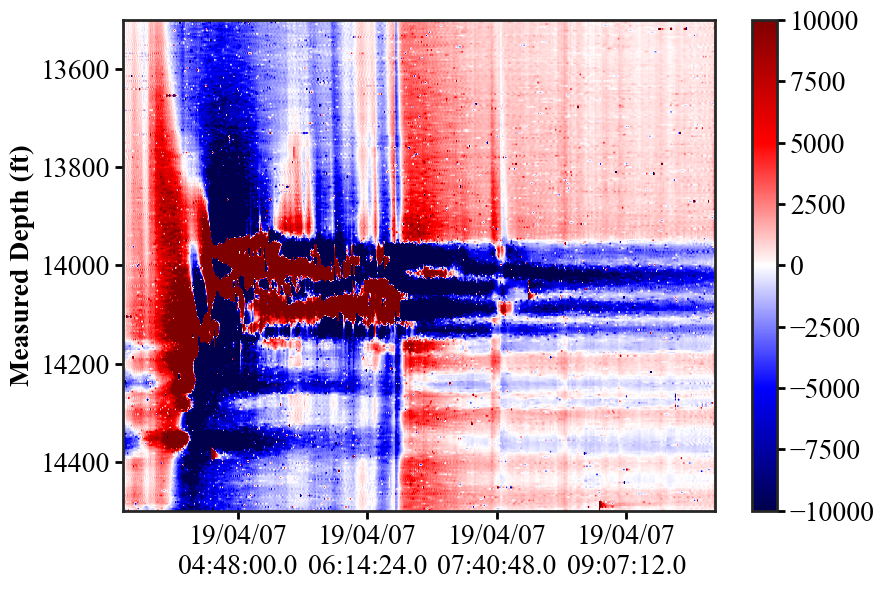

In [19]:

# 画瀑布图（对接你的 Data2D_XT）
cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')  # NaN 分隔带显示白色
DASdata = Data2D_XT.Data2D()
DASdata.data = data_tsub                 # (N_ch, M_t)
DASdata.taxis = t_sub                   # 仍然是“相对秒”
DASdata.daxis = md_sub                  # 现在是 MD（ft），含 NaN 分隔也 OK
DASdata.start_time = start_time       # 搭配 use_timestamp=True 才能显示绝对时间刻度

#adjust the size

fig, ax = plt.subplots(figsize=(9, 6))  # 宽 12 英寸，高 6 英寸

# DASdata.plot_waterfall(timescale='second',use_timestamp=True,timefmt = '%m/%d\n%H:%M:%S.{ms}')
DASdata.plot_waterfall(timescale='second', use_timestamp=True, cmap=plt.get_cmap('seismic'), xtickN=5)

ax = plt.gca()

plt.clim(-1e4, 1e4)
plt.colorbar()
plt.ylabel("Measured Depth (ft)")
# plt.xlabel('Date')
plt.tight_layout()
# plt.savefig('waterfall_HFTS2_S6.png')
plt.savefig('waterfall_HFTS2_S22.png')

